In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy import units as u
import astropy 

import pandas as pd

import loadSP as lsp
import cosmo
import halos
import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

def exp_formatter(x,pos):
    return format(x, '.2e')
expfmt  = FuncFormatter(exp_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.2669999897, Ob0=0.0445, name='myCosmo')
# Make sure we have halo information for this z... hop/...
z = 12.0
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
#boxsizecm = lsp.getBoxSize(num,"/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/")
# print("boxsize from info {:.2f} at z={}".format((boxsizecm * u.cm).to(u.kpc),z))

print("Using astropy cosmology: size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))


Using astropy cosmology: size 325.03 kpc


In [4]:
sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]

Boxsize from kKey file = 324.44 kpc


In [5]:
locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z)

In [6]:
baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
spAges = baseAge - bt/1e6
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))

min sp age 1.24 Myr
max sp age 180.15 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.13e-01 Solar


In [7]:
# import importlib
# importlib.reload(lsp)
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
# halosRawPos = halosRawPos[0:500]
#tbox = boxsizecm/lsp.cmInPc/1000.0 # Convert cm to kpc
tbox = sizeKeys[sizeKeys[::,0] == z][0,1]     # This works too.. 
# tbox = (3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc) # Last resort!
print("boxsize at z={:.2f} is {:.2f}".format(z,tbox))
halosPos = halosRawPos * tbox
len(halosRawPos)

boxsize at z=12.00 is 324.44


7103

In [8]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
astroPyCosmo = FlatLambdaCDM(H0=71.0, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [9]:
arcPerKpc = astroPyCosmo.arcsec_per_kpc_comoving(z=9.5)
print('Comoving:',arcPerKpc)
arcPerKpc = astroPyCosmo.arcsec_per_kpc_proper(z=9.5)
print('Proper:',arcPerKpc)


Comoving: 0.020734679928940715 arcsec / kpc
Proper: 0.21771413925387748 arcsec / kpc


In [10]:
kpcPerArcSec = cosmo.arcAtz(71,z=9.5,om=0.24, ol=1.0-0.24) # size of an arcsec at the specified reshift in kpc
print('Proper:',1.0 / kpcPerArcSec)


Proper: 0.21744697332907817


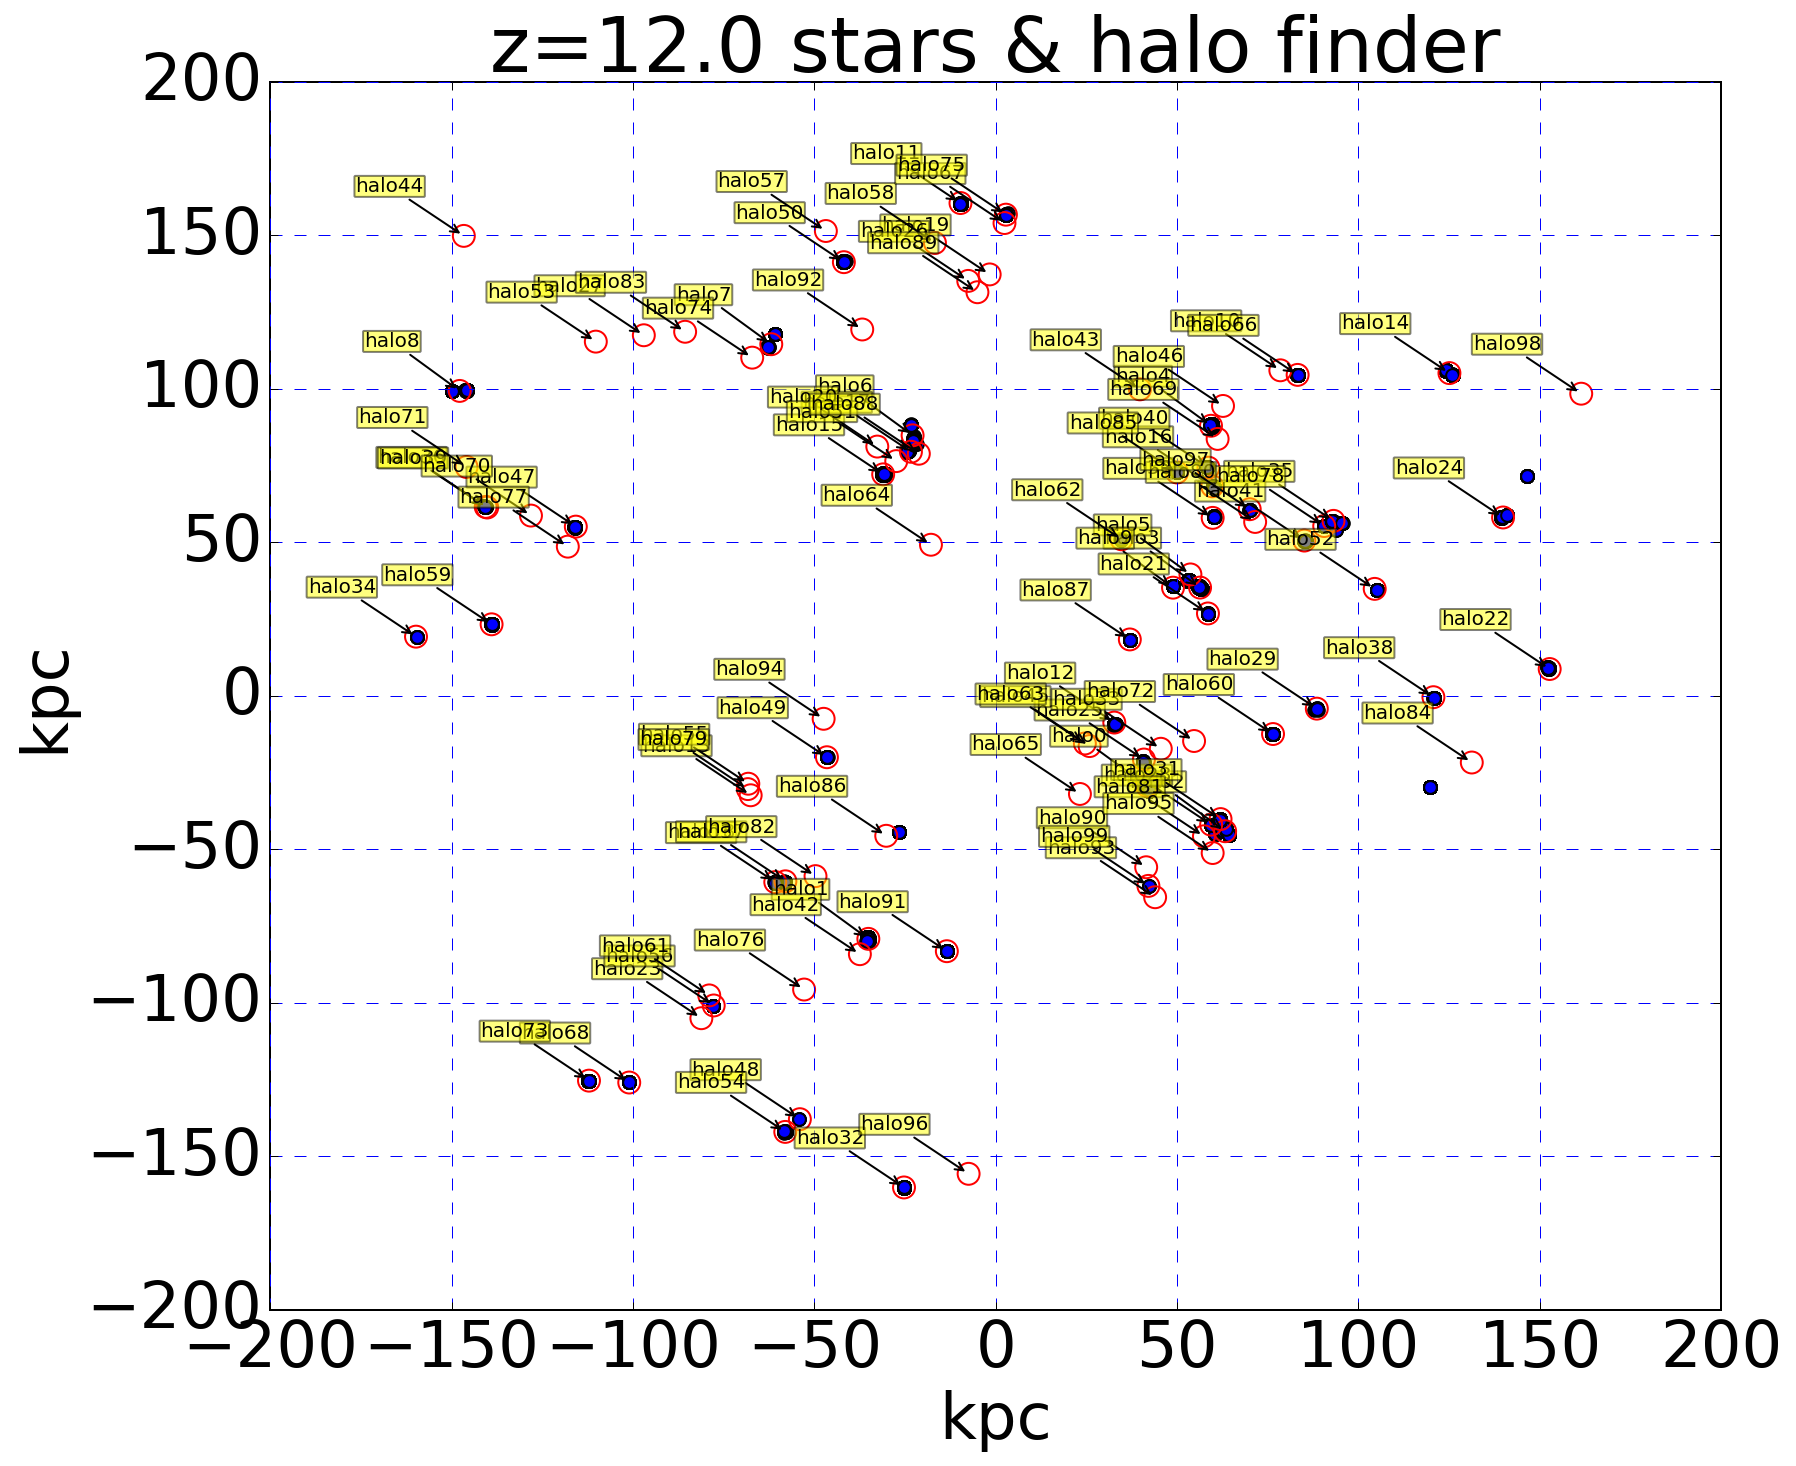

In [11]:
htp = 100
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0],halosPos[:htp,1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

11305

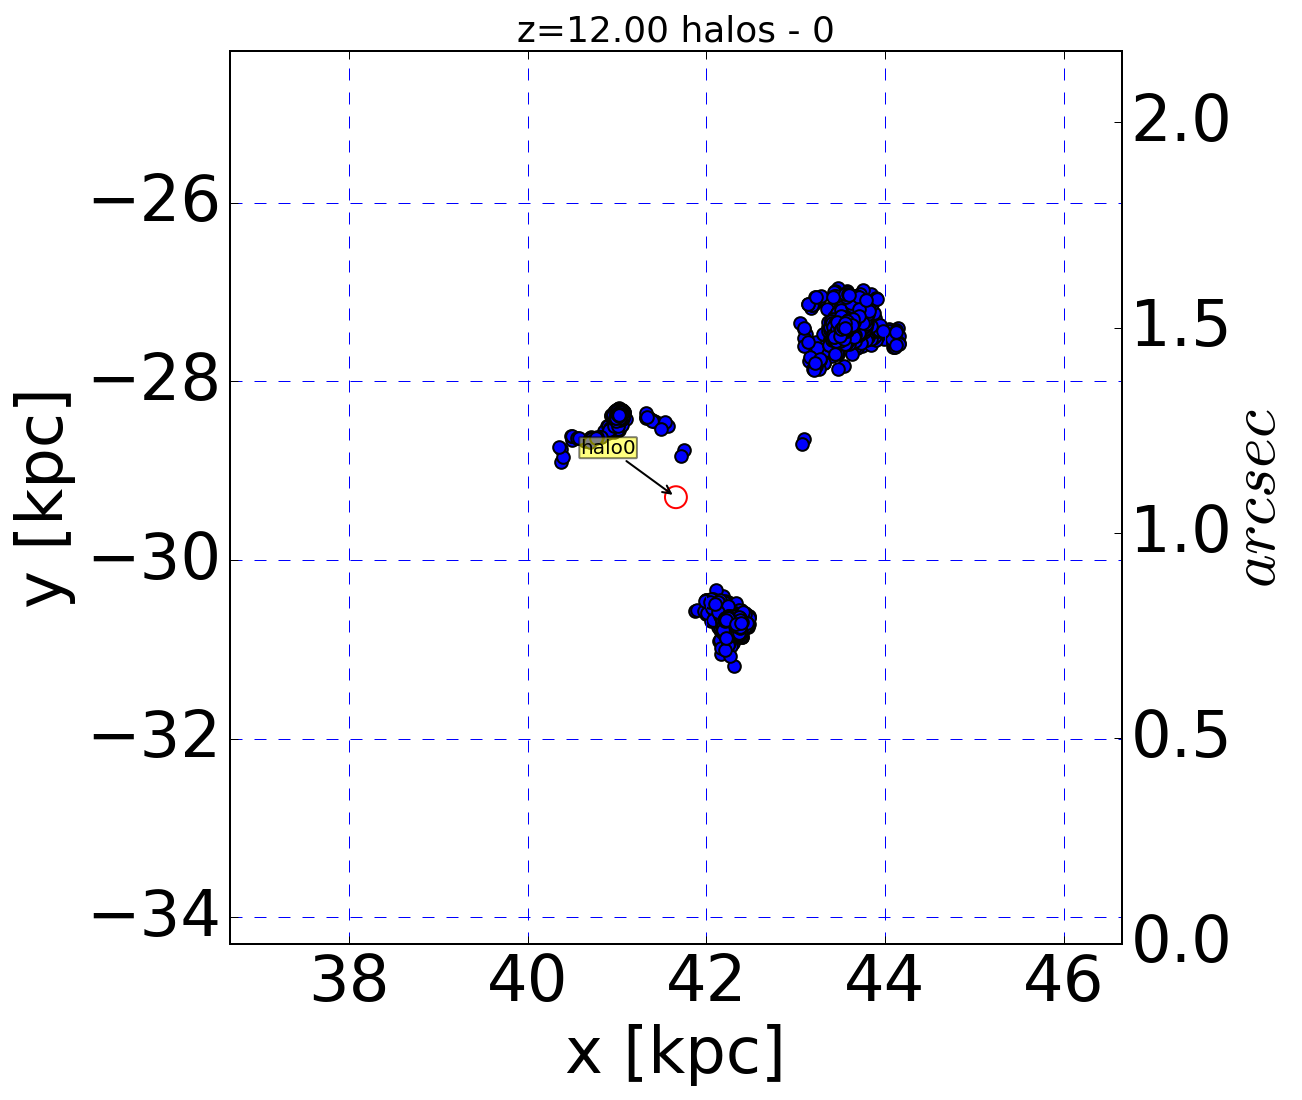

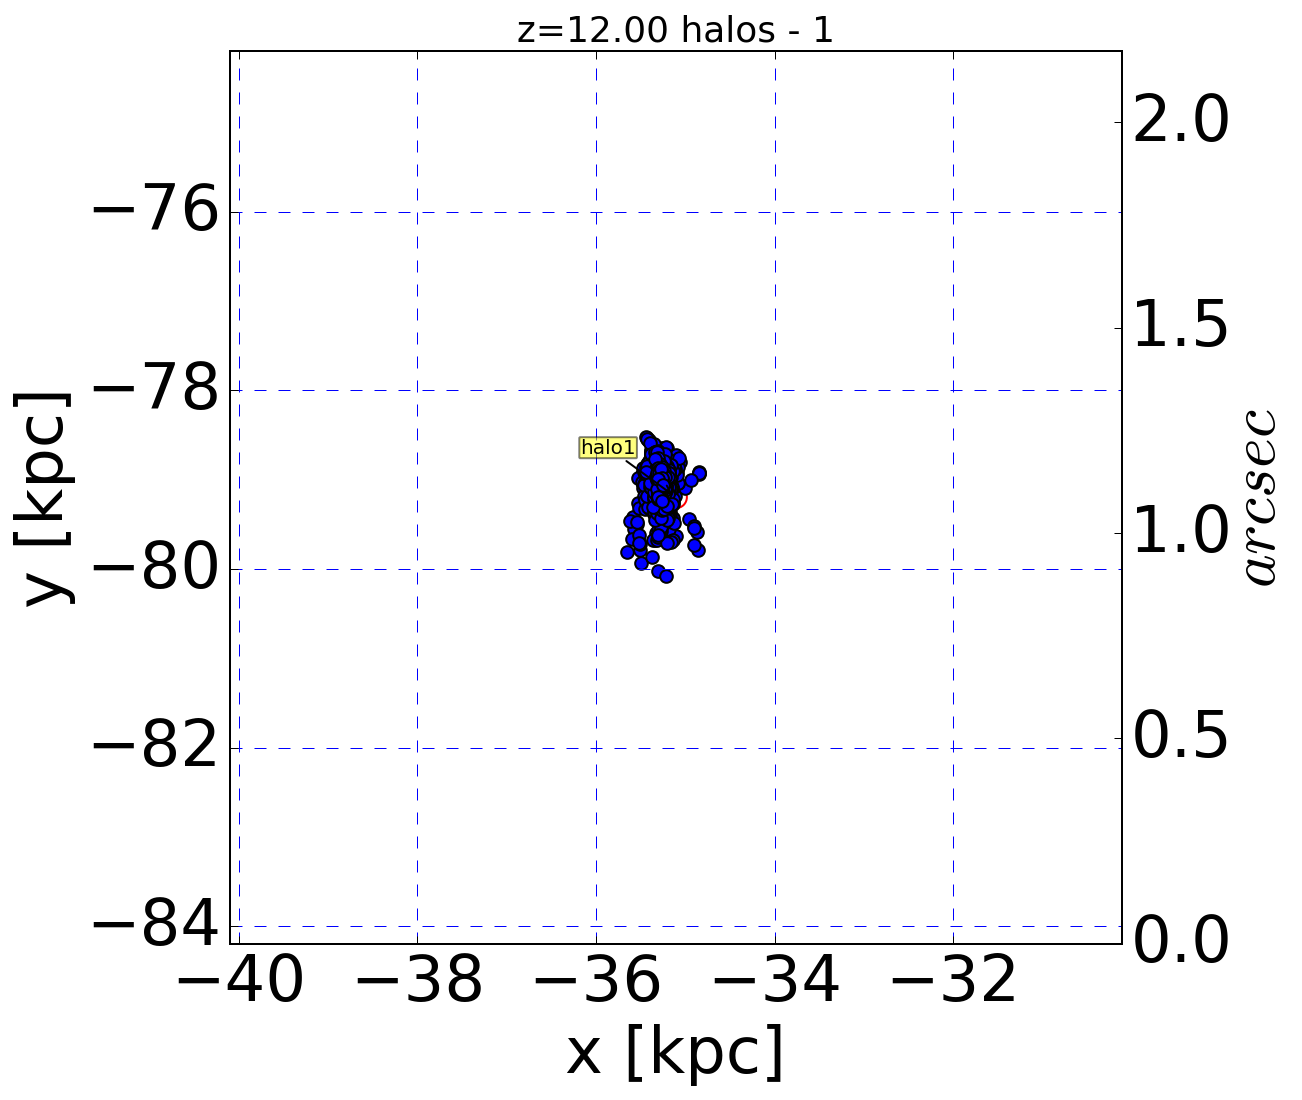

In [12]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = 10
for halo in range(0,2):
    ax=halos.pltView(locs,halosPos,halo,z,size)
    hax2 = ax.twinx()
    hax2.set_ylim([0,size/kpcPerArcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
gc.collect()

18.372715771737642 kpc = 4.0 arcsec
Num 5489, Tot Mass 4066617.0773890093 solMass
Num 9389, Tot Mass 7116680.662008287 solMass


10751

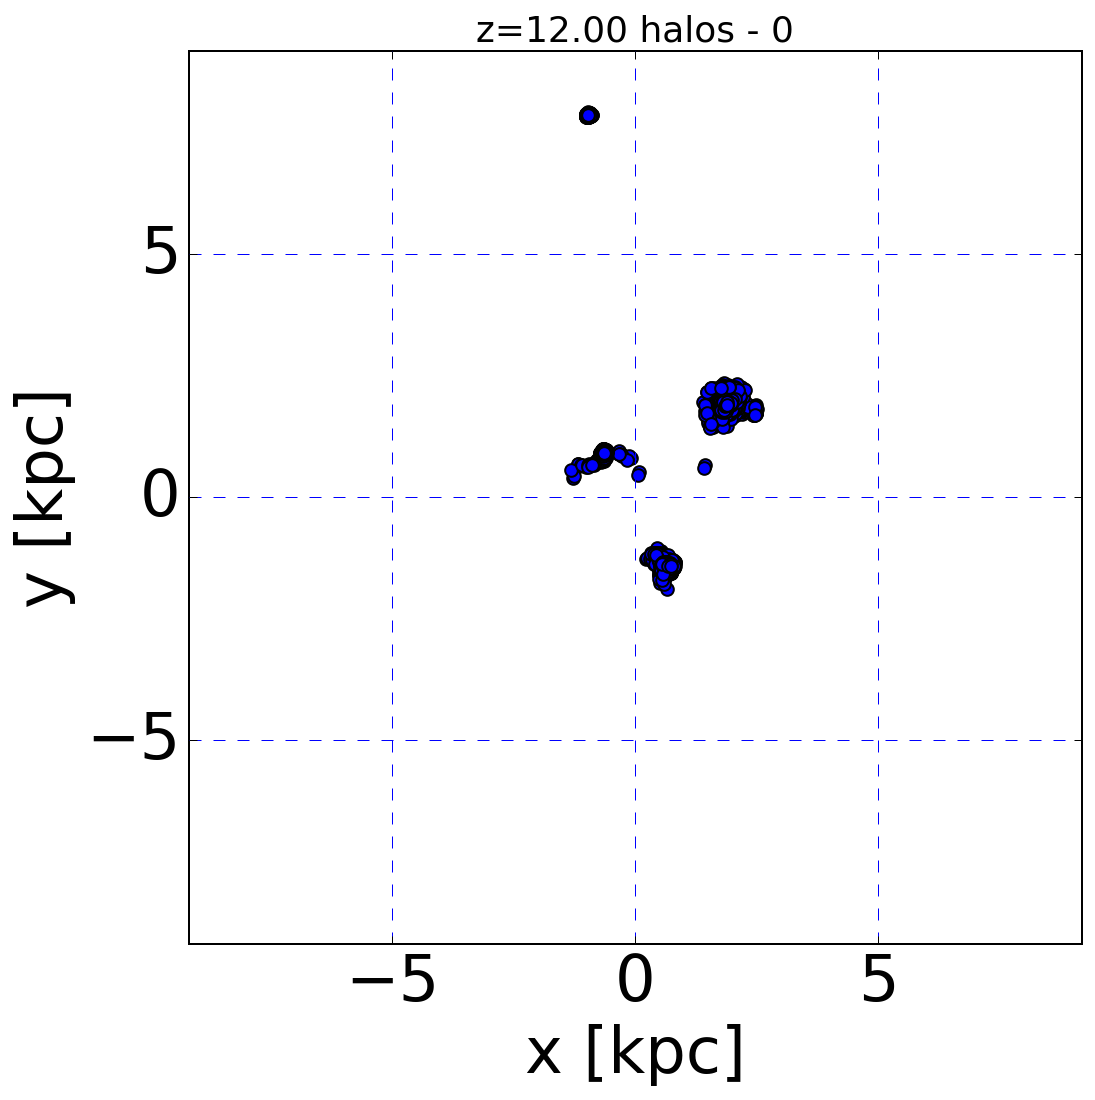

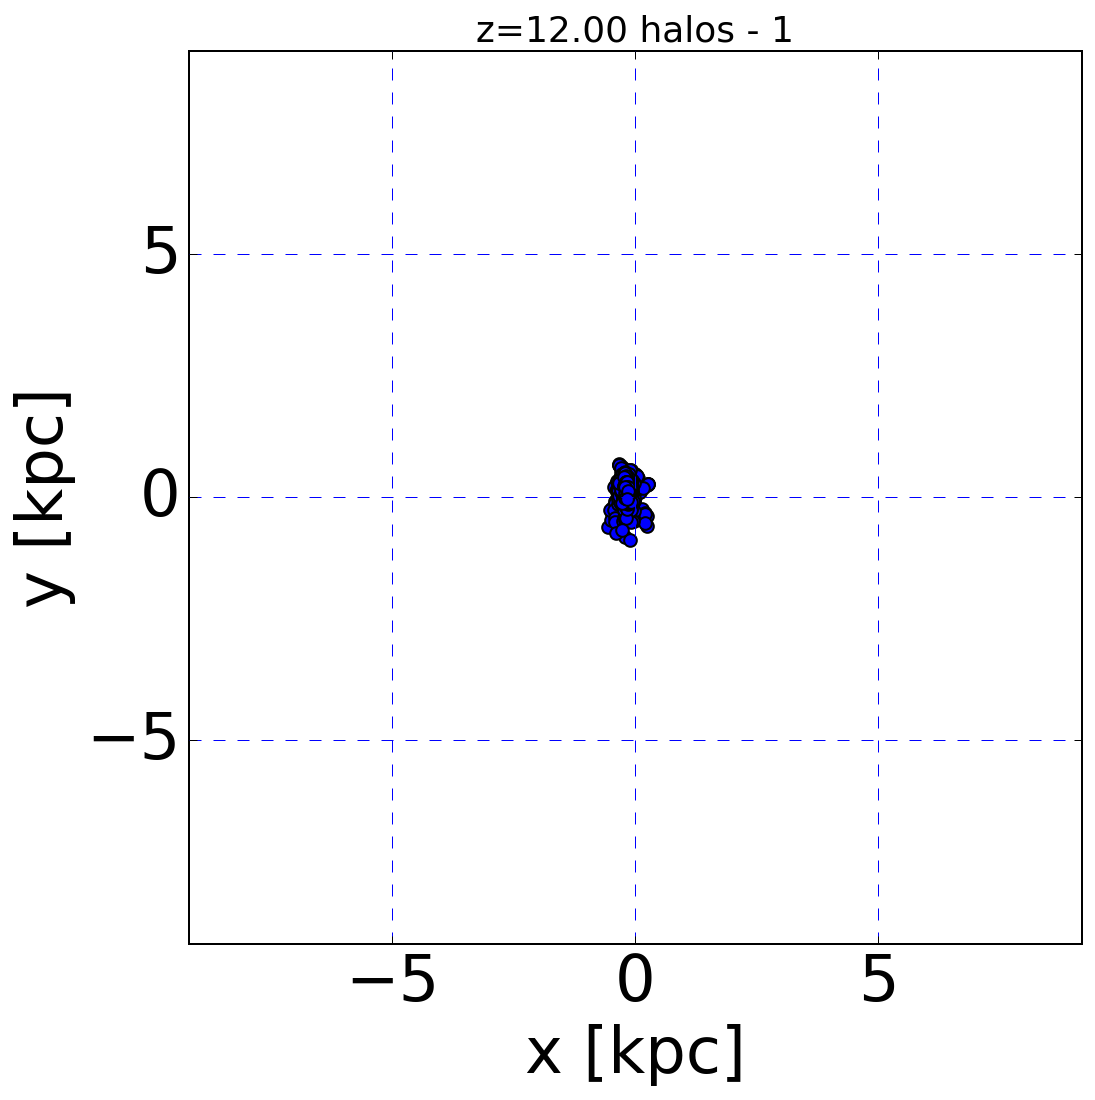

In [13]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = size.value
print("{} = {}".format(size * u.kpc,size * u.kpc* arcPerKpc))

for haloNum in range(0,2):
    # Load the stars for this halo
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getViewStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)
    print("Num {}, Tot Mass {}".format(len(halospmass),halospmass.sum() * u.solMass))

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.scatter(halosplocs[:,0],halosplocs[:,1],s=40,c='b') # Plot star particles
    ax.grid(b=True, which='major', color='b', linestyle='--')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
    ax.set_xlim([-size/2,size/2])
    ax.set_ylim([-size/2,size/2])
    
gc.collect()

In [13]:
size = 10 # kpc
numZeros = 0
nonZeros = 0
for indx,h in enumerate(halosPos):
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,indx,size)
    if (len(halospmass) > 0):
        nonZeros += 1
    else:
        numZeros += 1
print('Num zero len halos', numZeros)
print('Non zero len halos', nonZeros)

Num zero len halos 5316
Non zero len halos 1787


# Plot halo-specific histograms

Load the relevant data from min/max age & min/max Z @ redshift we are working
For array that map to lower Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at lower Z at exact age
For array that map to upper Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at upper Z at exact age
Interpolate value at exact Z using exact age value at lower/uppper Z

In [14]:
from scipy.interpolate import interp1d

In [15]:
pop3Flux14 = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',',names=True)
Zem7Flux14 = np.genfromtxt('Zem7_14.0.gz',dtype=float, delimiter=',',names=True)

In [16]:
pop3Flux14['f210m'][pop3Flux14['LogAge'] == 4.0], Zem7Flux14['f210m'][Zem7Flux14['LogAge'] == 4.0]

(array([  2.86740000e-38]), array([  4.89540000e-39]))

In [17]:
print(pop3Flux14.dtype.names)

('LogAge', 'redshift', 'f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


419

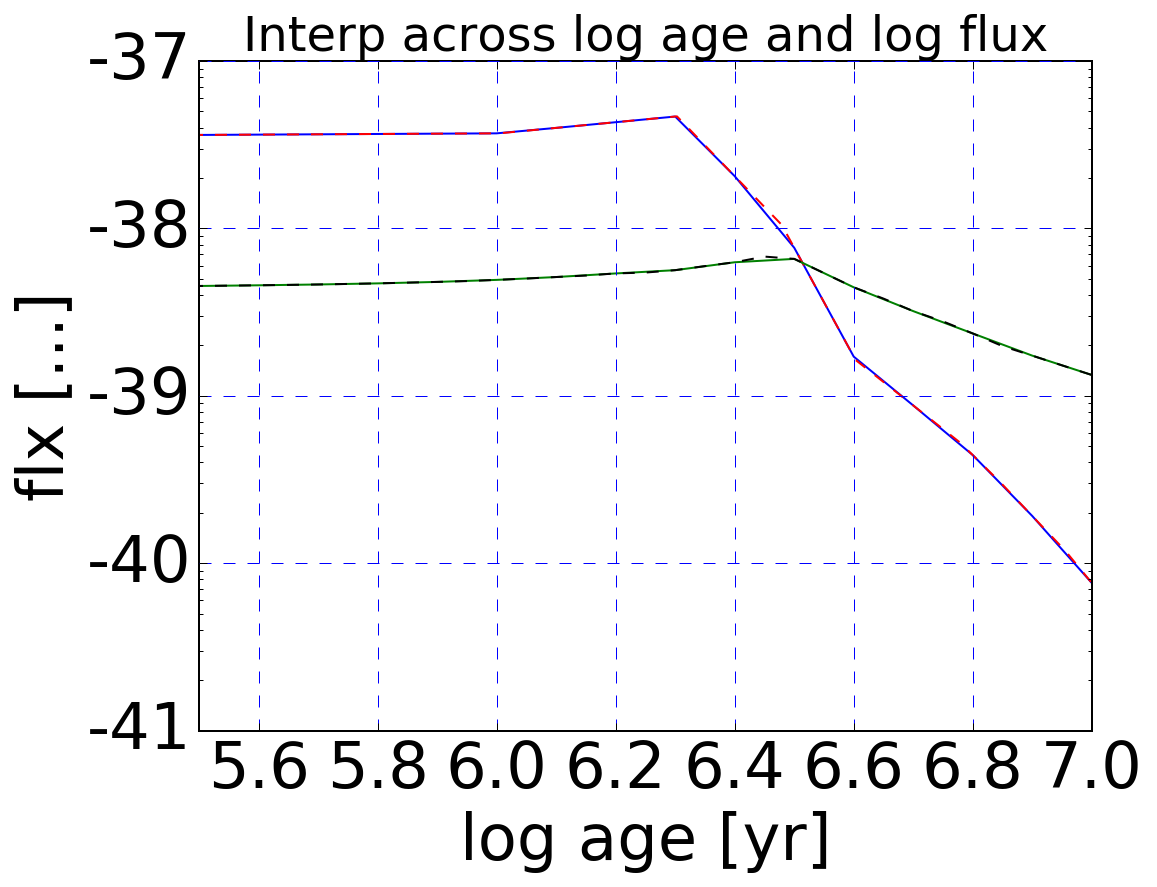

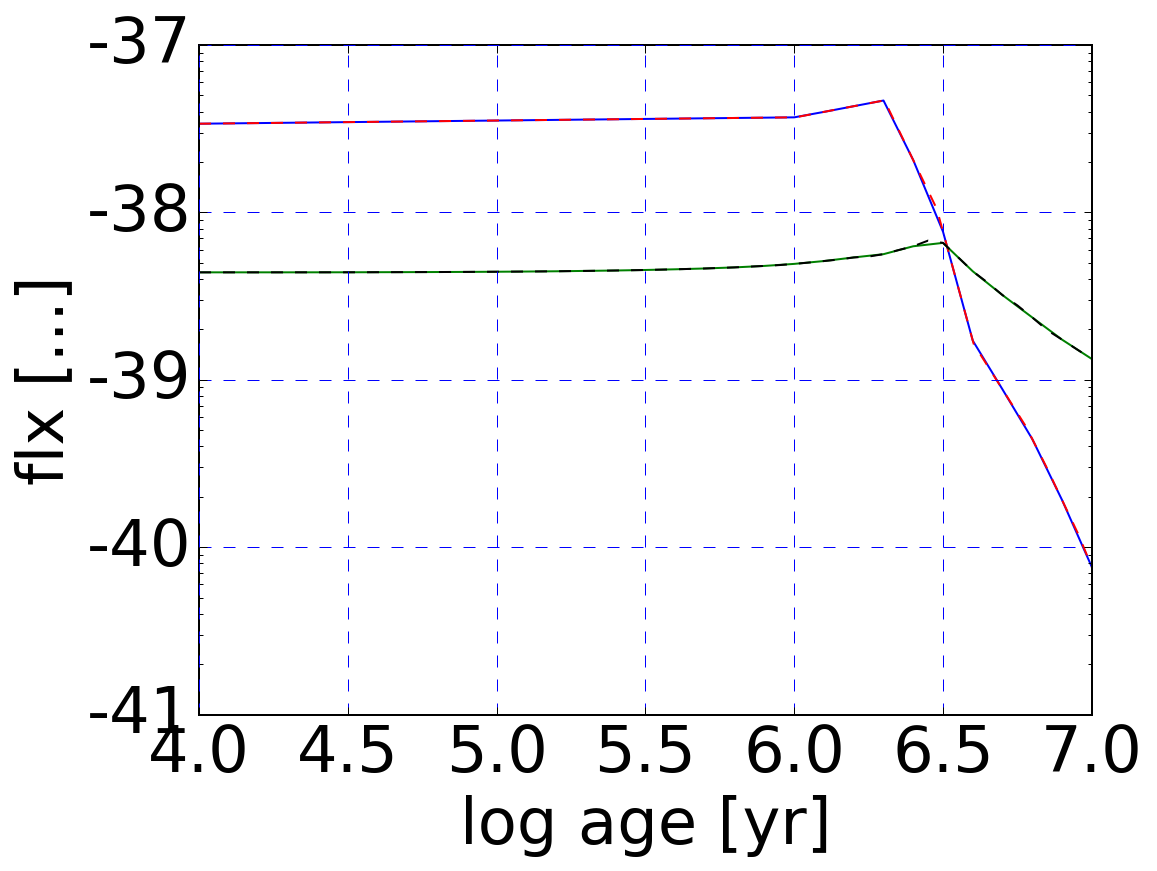

In [18]:
# How about an interpolating function for each file (2 files for upper/lower Z)\
# Tested using Log Age for the interp on 8 Aug --- interpolate using LOG age provides a closer fit to 
# the orig curve
pop3Flux14Interp = interp1d(pop3Flux14['LogAge'],np.log10(pop3Flux14['f335m']),kind='linear')
Zem7Flux14Interp = interp1d(Zem7Flux14['LogAge'],np.log10(Zem7Flux14['f335m']),kind='linear')

logAgeRng = np.arange(4,9,0.1)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,10**pop3Flux14Interp(logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,10**Zem7Flux14Interp(logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([5.5,7])
ax.set_ylim([1e-41,1e-37])
ax.set_title('Interp across log age and log flux',size=24)

gc.collect()

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,10**pop3Flux14Interp(logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,10**Zem7Flux14Interp(logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([4,7])
ax.set_ylim([1e-41,1e-37])
    
gc.collect()

In [58]:
# Best to use Log Age, Log Flux

In [59]:
import logInterp

419

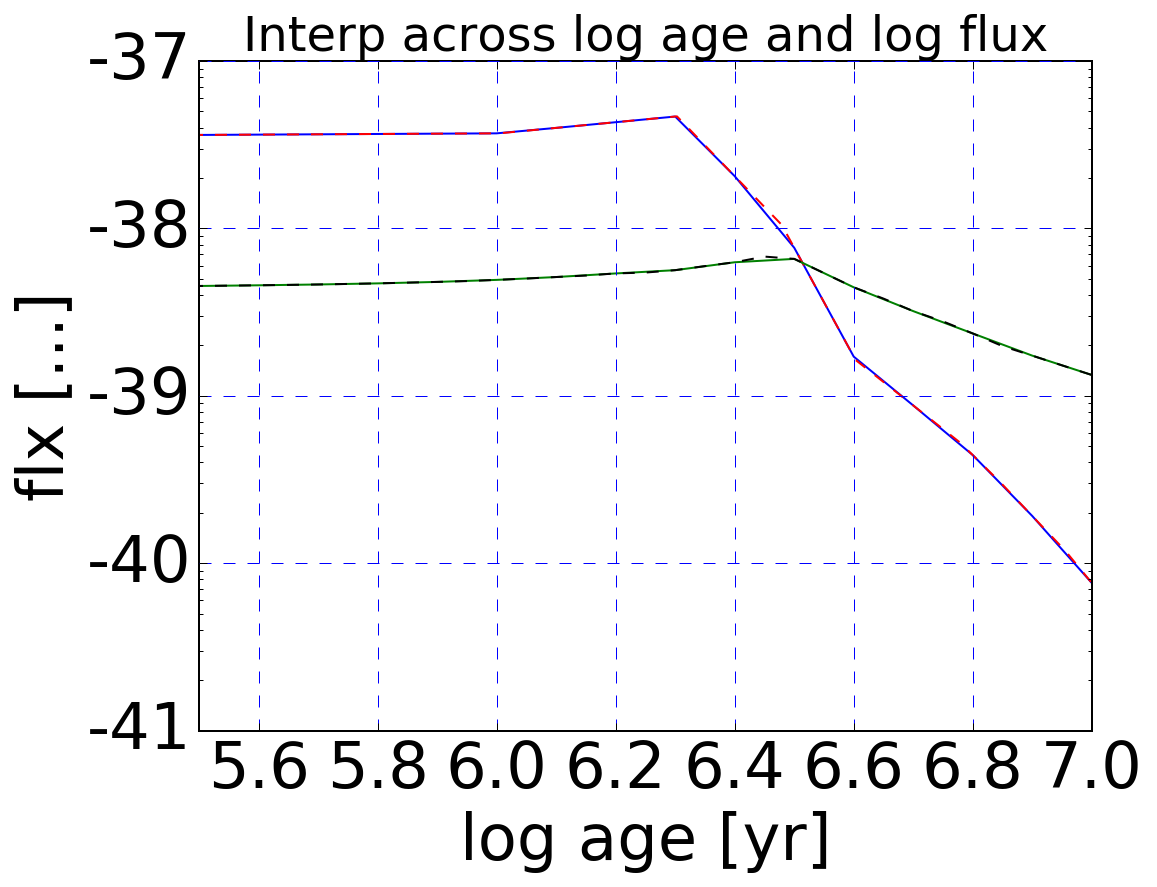

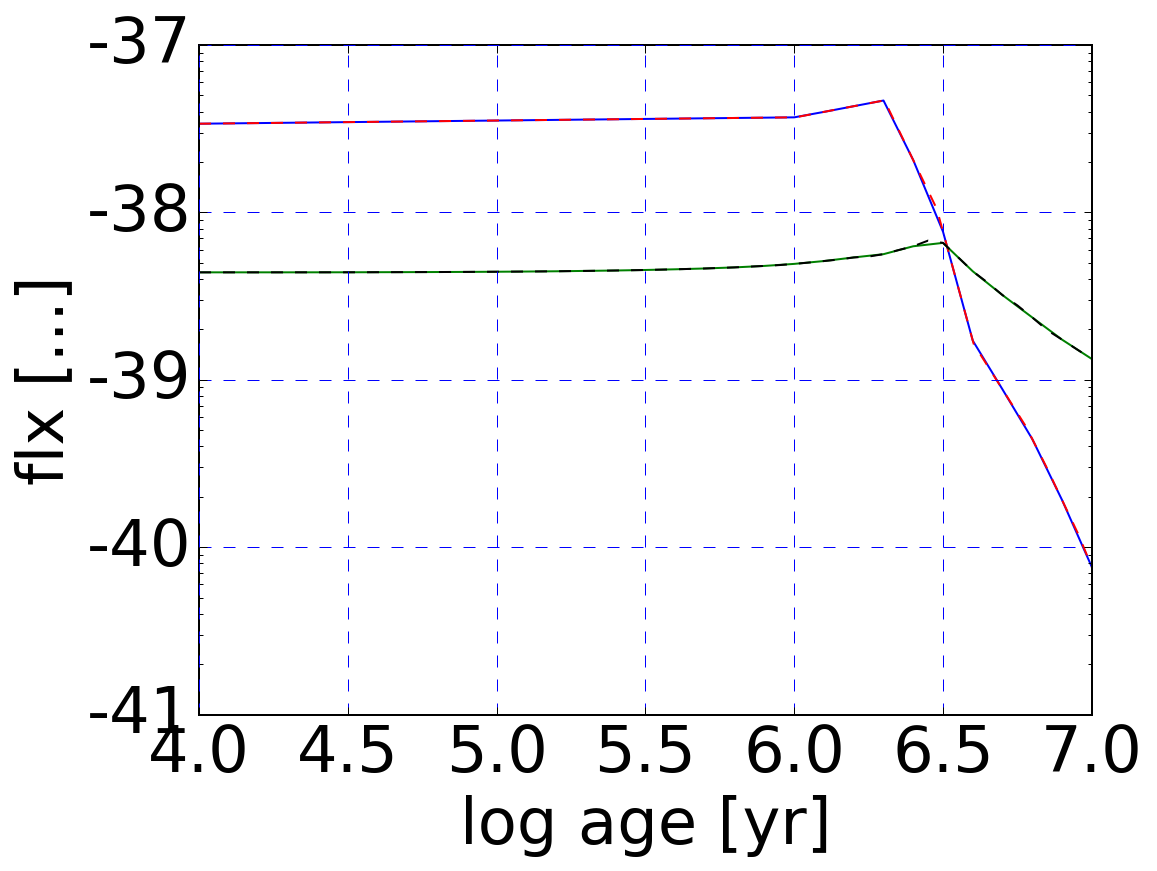

In [24]:
# How about an interpolating function for each file (2 files for upper/lower Z)\
# USING my LIBRARY LOG INTERP routine... 
pop3Flux14Interp = logInterp.log_interp1d(10**pop3Flux14['LogAge'],pop3Flux14['f335m'])
Zem7Flux14Interp = logInterp.log_interp1d(10**Zem7Flux14['LogAge'],Zem7Flux14['f335m'])

logAgeRng = np.arange(4,9,0.1)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,pop3Flux14Interp(10**logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,Zem7Flux14Interp(10**logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([5.5,7])
ax.set_ylim([1e-41,1e-37])
ax.set_title('Interp across log age and log flux',size=24)

gc.collect()

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,pop3Flux14Interp(10**logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,Zem7Flux14Interp(10**logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([4,7])
ax.set_ylim([1e-41,1e-37])
    
gc.collect()

In [25]:
print('min/max Myr',spAges.min(),spAges.max())
np.log10([spAges.min()*1e6,spAges.max()*1e6])

min/max Myr 1.2433390104 180.149774355


array([ 6.09458956,  8.25563372])

In [26]:
print('min/max Z',Z.min()*0.02,Z.max()*0.02)
# Remember, Z = 1e-10 as a mass fraction is essentially Z = 0.0

min/max Z 1e-10 0.0022516272172


In [27]:
pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)

(2.9417225199544863e-38, 4.3844999999999689e-39)

In [28]:
#
# USE A LOG interpolation now that we have filter flux for our age range in two interpolating functions
#
filt335mInterp = logInterp.log_interp1d([1e-100,1e-7],[pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)])

20593

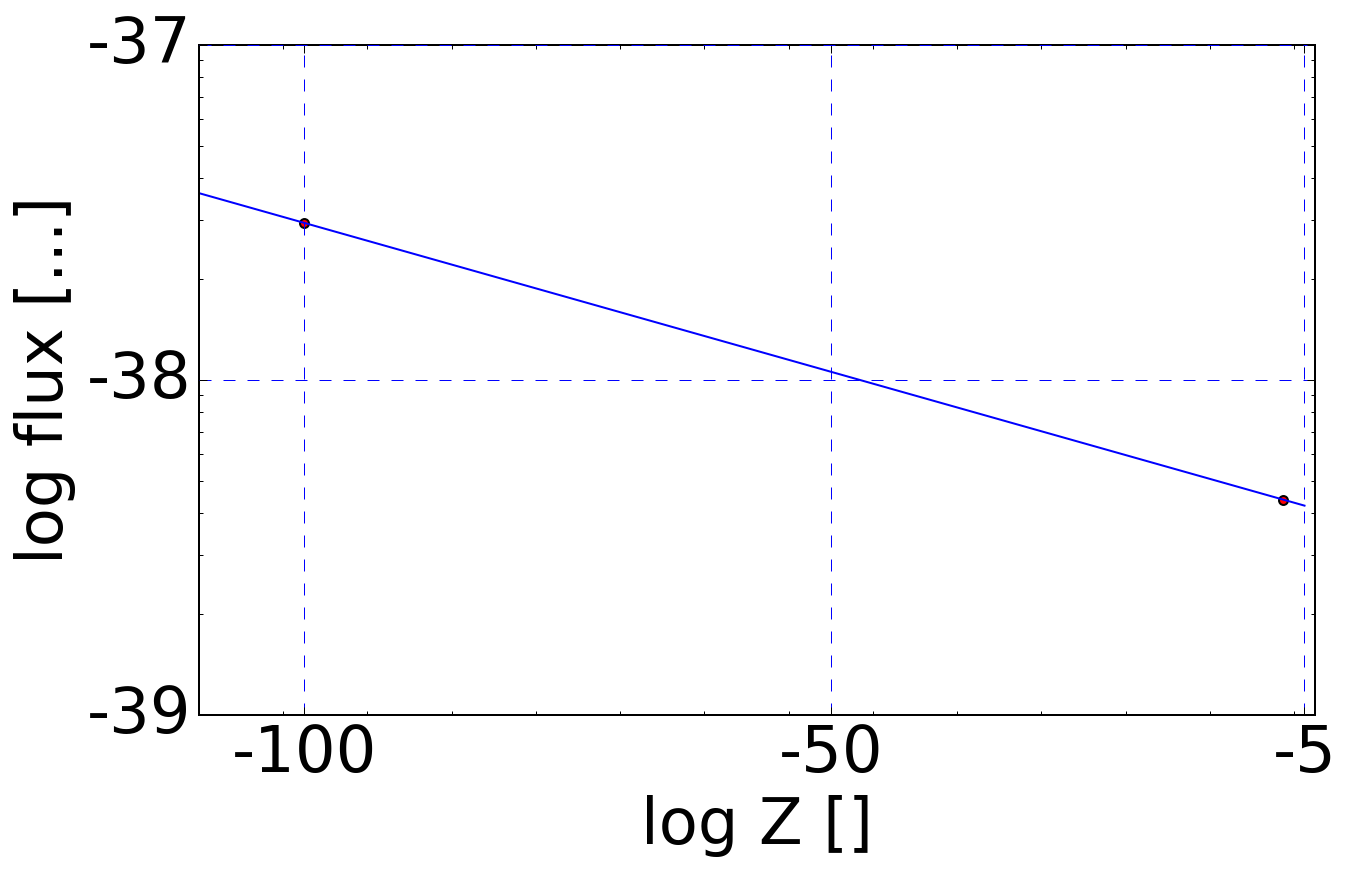

In [29]:
Zrng = np.logspace(-110,-5,100)

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(Zrng,filt335mInterp(Zrng),'b') # Plot star particles
ax.scatter([1e-100,1e-7],[pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)],s=20,c='r') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log Z []')
ax.set_ylabel('log flux [...]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xticks([1e-100,1e-50,1e-5])
# ax.set_ylim([-size/2,size/2])
    
gc.collect()

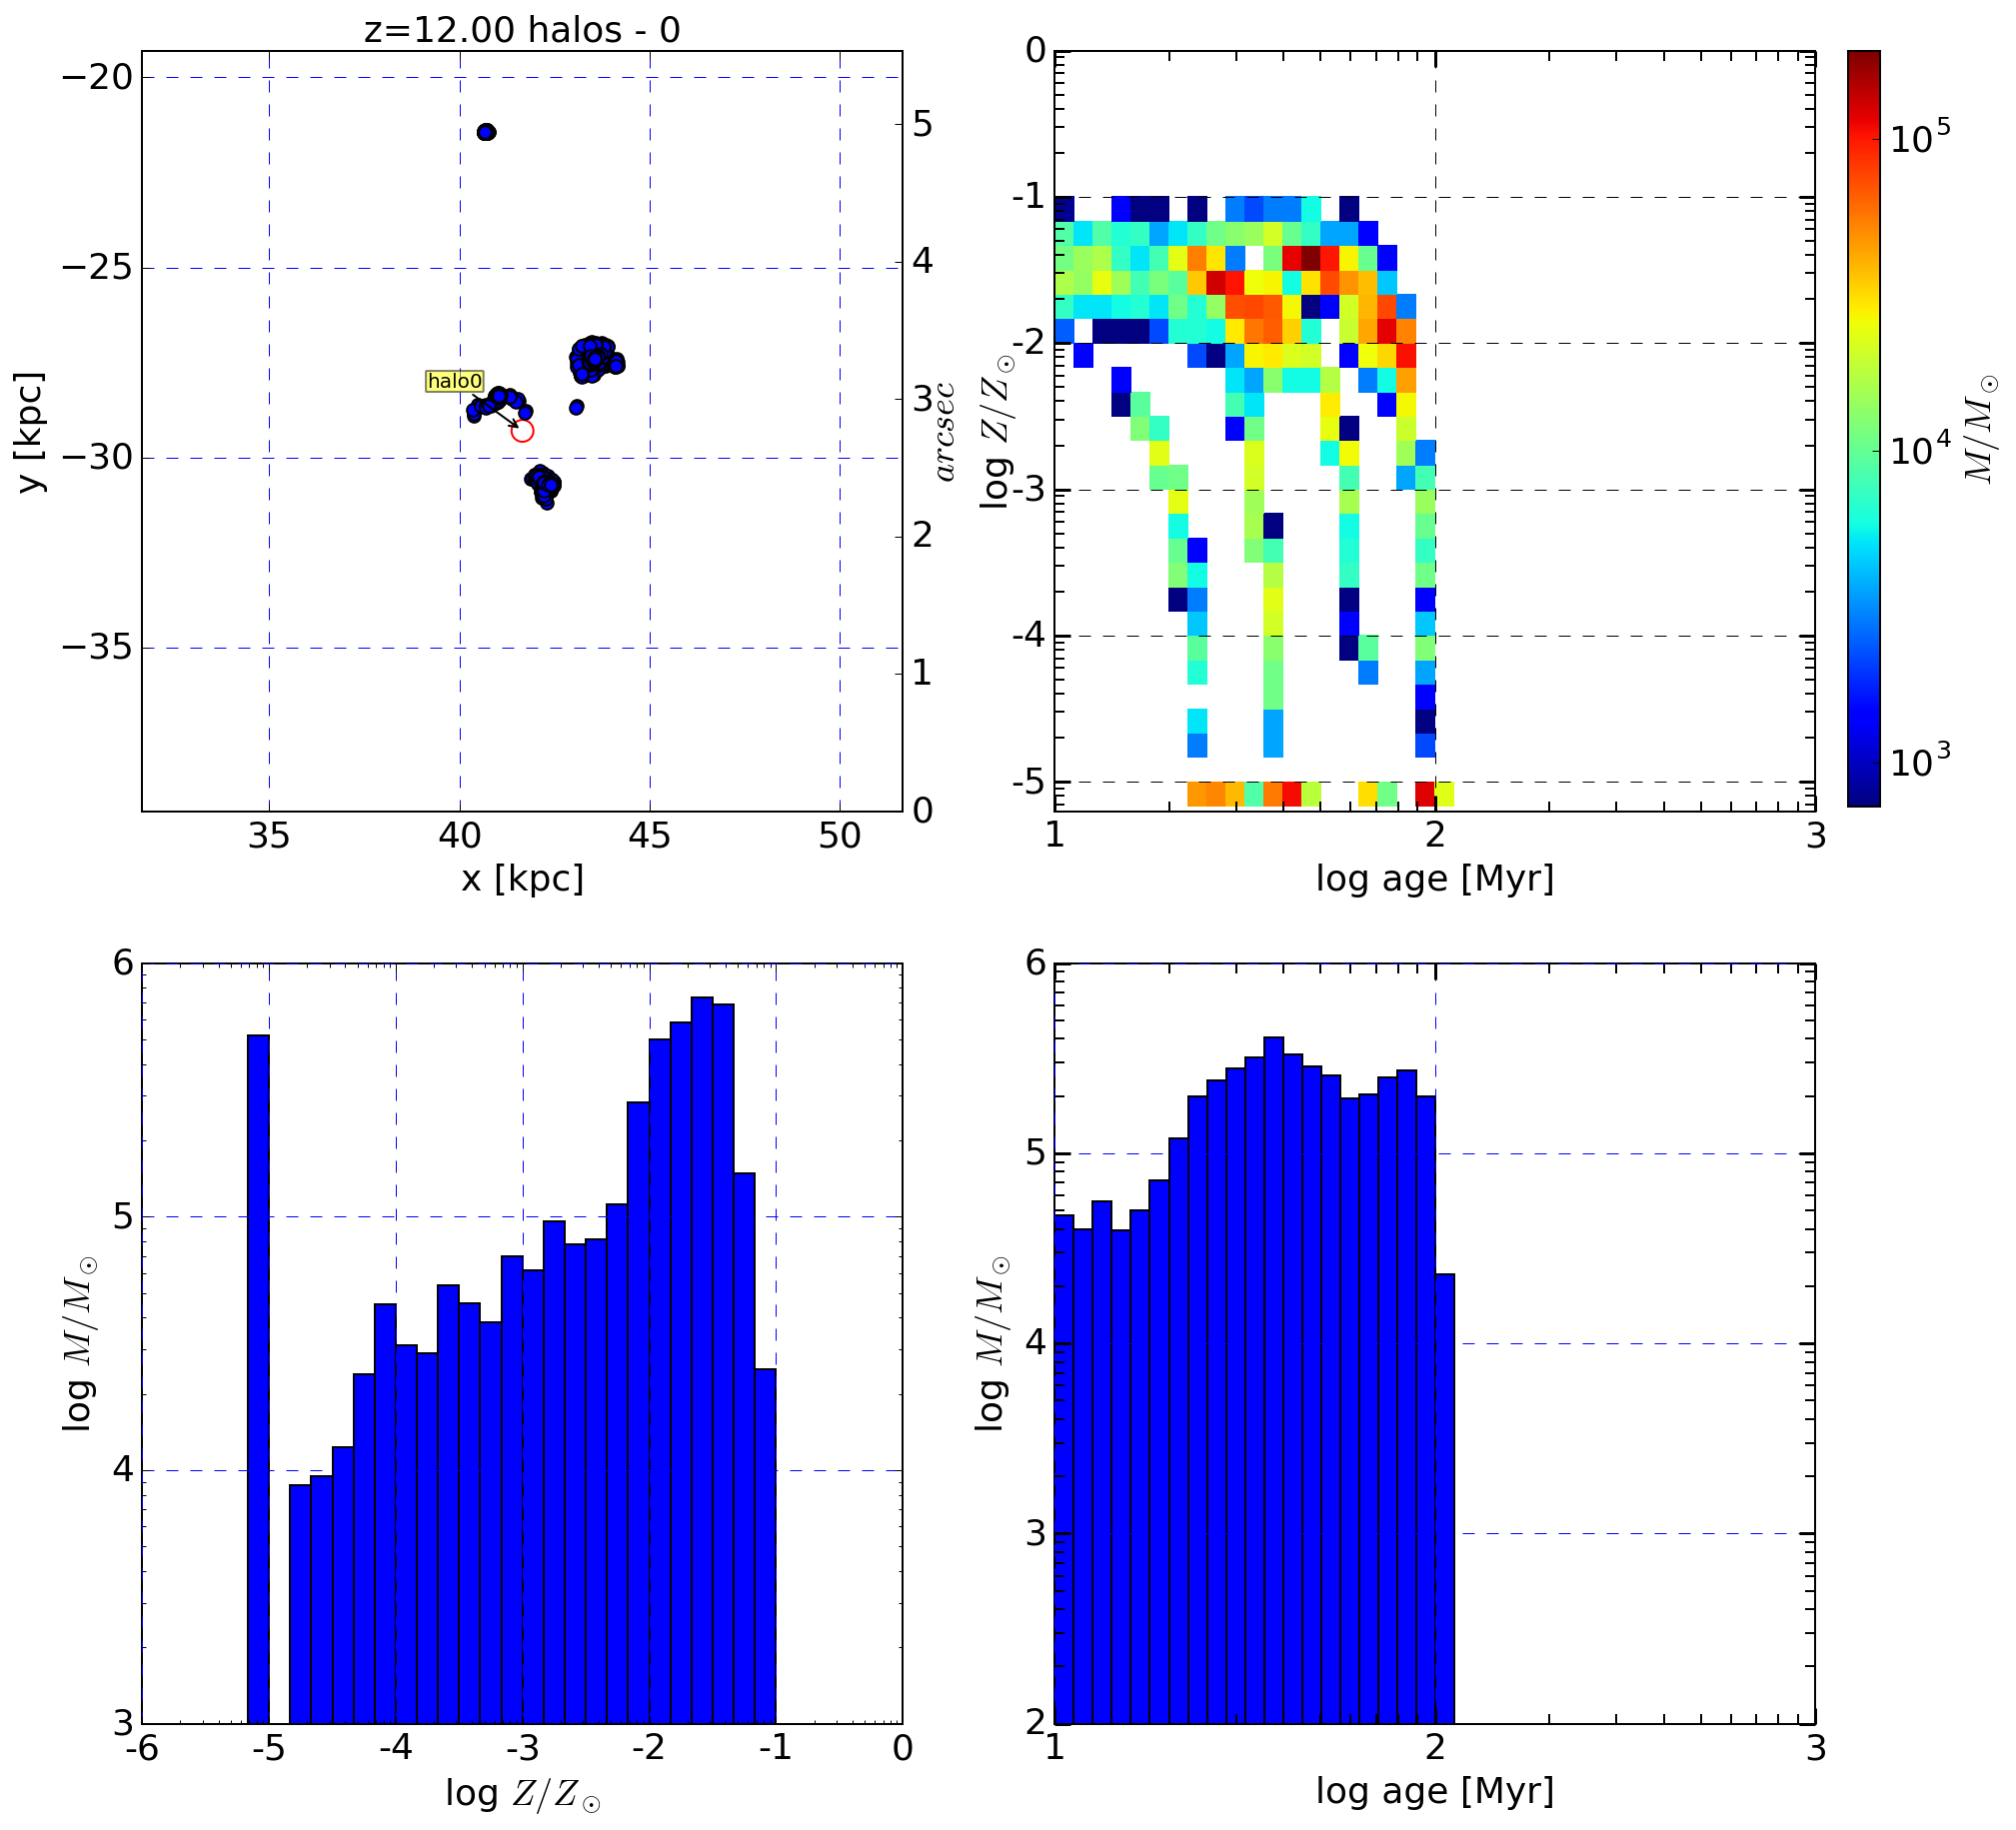

In [30]:
plt.rcParams['font.size'] = 18
cmap = plt.cm.jet
size = 10.0
for haloNum in range(0,1):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 15))
    #
    # Star particles for halo haloNum
    #

    arcSec = cosmo.arcAtz(71,z)

    #
    # Plot the halo star particles - scatter
    #
    size = 20
    hax=halos.pltView(locs,halosPos,haloNum,z,size,ax=ax1)
    origXlim=hax.get_xlim()
    origYlim=hax.get_ylim()

    # Add axis with arcsec scale
    hax2 = hax.twinx()
    hax2.set_ylim([0,size/arcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    hax.set_xlim(origXlim)
    hax.set_ylim(origYlim)

    # Load the stars for this halo
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)

    #
    # Metallicity of the halo star particles - histogram
    #
    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    ZBins   = np.logspace(-6,0,37)
    ax3.hist(Zfixed,bins=ZBins,weights=halomass)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.xaxis.set_major_formatter(logfmt)
    ax3.yaxis.set_major_formatter(logfmt)
    ax3.grid(b=True, which='major', color='b', linestyle='--')
    ax3.set_xlabel(r'log $Z/Z_\odot$')
    ax3.set_ylabel(r'log $M/M_\odot$')

    #
    # Age of halo star particles - histogram
    #
    ageBins = np.logspace(0,3,61) # TO match the SEDs we have from Schaerer, use 0.05 dex steps

    n, bins, patches = ax4.hist(haloages,bins=ageBins, weights=halomass)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.xaxis.set_major_formatter(logfmt)
    ax4.yaxis.set_major_formatter(logfmt)
    ax4.grid(b=True, which='major', color='b', linestyle='--')
    ax4.tick_params('both', length=5, width=1, which='minor')
    ax4.tick_params('both', length=8, width=1.5, which='major')
    ax4.set_xlabel('log age [Myr]')
    ax4.set_ylabel(r'log $M/M_\odot$')
    ax4.set_xlim([10,1000])
    
    #
    # 2D histogram, Z vs age
    #
    ageBins = np.logspace(0,3,61) # match the SEDs we have from Schaerer, use 0.05 dex steps

    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    # Can't use matplotlib with log axis... is screws it up.
    # n, aBins, metBins, image = ax.hist2d(ages,Zfixed,bins=(ageBins,ZBins),norm=LogNorm(),
    #                                    weights=mass)
    # Need to use numpy...
    n, aBins, metBins = np.histogram2d(Zfixed,haloages,bins=(ZBins,ageBins),
                                            weights=halomass)
    histax = ax2.pcolormesh(ageBins, ZBins, n, norm=LogNorm())

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(logfmt)
    ax2.yaxis.set_major_formatter(logfmt)
    ax2.grid(b=True, which='major', color='k', linestyle='--')
    ax2.tick_params('both', length=5, width=1, which='minor')
    ax2.tick_params('both', length=8, width=1.5, which='major')
    ax2.set_xlabel(r'log age [Myr]')
    ax2.set_ylabel(r'log $Z/Z_\odot$')
    ax2.set_xlim([10,1000])
    ax2.set_ylim([10**-5.2,1])
    cax = fig.add_axes([0.915, 0.55, 0.015, 0.35])
    fig.colorbar(histax, cax=cax, label="$M/M_\odot$")
    ax2.yaxis.labelpad = -4

    #plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.1, hspace=.1)


# Real analysis... 


In [75]:
halospZ

array([ 0.00056234,  0.00067364,  0.00052184, ...,  0.00028395,
        0.00049795,  0.00063377])

In [76]:
halospages.min(),halospages.max(),len(halospZ)

(1.5451127259677264, 102.8607113086012, 5135)

In [77]:
# pop3Flux_14 = pd.read_csv('pop3TE_14.0.gz',dtype=float, delimiter=',')
# Zem7Flux_14 = pd.read_csv('Zem7_14.0.gz',dtype=float, delimiter=',')
# Zem5Flux_14 = pd.read_csv('Zem5_14.0.gz',dtype=float, delimiter=',')
# SB990004_14 = pd.read_csv('SB990004_14.0.gz',dtype=float, delimiter=',')
# SB99004_14 = pd.read_csv('SB99004_14.0.gz',dtype=float, delimiter=',')
# SB99008_14 = pd.read_csv('SB99008_14.0.gz',dtype=float, delimiter=',')
# SB9902_14  = pd.read_csv('SB9902_14.0.gz',dtype=float, delimiter=',')
# filternames = np.array(pop3Flux14).dtype.names[2::]

In [78]:
pop3Flux_14 = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',',names=True)
Zem7Flux_14 = np.genfromtxt('Zem7_14.0.gz',dtype=float, delimiter=',',names=True)
Zem5Flux_14 = np.genfromtxt('Zem5_14.0.gz',dtype=float, delimiter=',',names=True)
SB990004_14 = np.genfromtxt('SB990004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99004_14 = np.genfromtxt('SB99004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99008_14 = np.genfromtxt('SB99008_14.0.gz',dtype=float, delimiter=',',names=True)
SB9902_14  = np.genfromtxt('SB9902_14.0.gz',dtype=float, delimiter=',',names=True)
filternames = np.array(pop3Flux14).dtype.names[2::]

In [79]:
print(filternames) # Just the filter names, skipped "LogAge" and "Z"

('f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


In [80]:
pop3Flux_14['f115w'][0:10],np.log10(pop3Flux_14['f115w'])[0:10]
# np.ma.masked_less_equal(pop3Flux_14[filt],0.0)

(array([  4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199]),
 array([-198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209]))

In [122]:
#
# Generate interpolating functions for each metallicity over the age range computed for that Z
#
flux = {0:   {filt : interp1d(pop3Flux_14['LogAge'],
                              np.log10(np.ma.masked_less_equal(pop3Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-7: {filt : interp1d(Zem7Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem7Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-5: {filt : interp1d(Zem5Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem5Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-4: {filt : interp1d(SB990004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB990004_14[filt],0.0)),kind='linear') for filt in filternames},
       8e-3: {filt : interp1d(SB99008_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99008_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-3: {filt : interp1d(SB99004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99004_14[filt],0.0)),kind='linear') for filt in filternames},
       2e-2: {filt : interp1d(SB9902_14['LogAge'],np.log10(np.ma.masked_less_equal(SB9902_14[filt],0.0)),kind='linear') for filt in filternames}
       }

In [82]:
#
# We have different age ranges, spacing for the different types of flux files...
pop3Flux_14['LogAge'][0:5], Zem7Flux_14['LogAge'][0:5], SB99008_14['LogAge'][0:5] , SB9902_14['LogAge'][0:5] 

(array([ 4.   ,  6.004,  6.303,  6.479,  6.603]),
 array([ 4.  ,  4.05,  4.1 ,  4.15,  4.2 ]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]))

In [83]:
print(10**flux[0]['F225W_WFC3']([4.,6.004]), 10**flux[1e-7]['F225W_WFC3']([4.,4.05]))
print(10**flux[8e-3]['f115w']([4.,6.3032]), 10**flux[8e-3]['Ks']([4.,6.3032]))

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


In [84]:
print(pop3Flux14['F225W_WFC3'][0:2], Zem7Flux_14['F225W_WFC3'][0:2])
print(SB99008_14['f115w'][0:2] , SB99008_14['Ks'][0:2])  # Matches our interpolators ... 

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


# The Algo

In [ ]:
redshifts    = [5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
haloFiles    = [241, 215, 191, 152, 136, 121, 108, 97, 84, 73, 58, 43, 33, 26, 20, 16]

In [ ]:
halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,0,10.0) # halo stars 10 kpc radius
halospZ  = halospZ * 0.02 # back to mass fraction
halospPZ = halospPZ * 0.02

In [ ]:
#
# HERE's the main loop
#
#
filename = 'haloFluxes_z_' + str(z) + "_.txt" 
outfile = []
# for indx,h in enumerate(halosPos):
for indx in np.arange(10):
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,indx,10.0)
    if (len(halospmass) == 0):
        continue
    print()
    print("Working on halo {} with {} star particles.".format(indx,len(halospmass)))
    halospZ  = halospZ * 0.02 # back to mass fraction
    halospPZ = halospPZ * 0.02

    haloFiltTots = dict.fromkeys([filt for filt in filternames], 0.0) # Initialize filter totals for this halo
    headerStr  = 'indx, M/M_sun, <Z>/Z_sun, <Z_P>/Z_sun, '
    headerStr += ', '.join([f for f in haloFiltTots.keys()])
    Zs = sorted(flux.keys())
    for spZ,spAge,spMass in zip(halospZ,np.log10(halospages*1e6),halospmass): # Z,PZ are now mass fractions, as in flux files
        for filt in filternames:
            theFluxFunc = interp1d(np.log10([aZ for aZ in Zs]),          # x = Log of each Z for which we have a table... 
                                   [flux[aZ][filt](spAge) for aZ in Zs], # y = Log of flux at each Z at age = spAge
                                   kind='linear')
            # So now theFluxFunc is f(log10(Z))=log10(flux) at spAge
            theFluxForStar = 10**theFluxFunc(np.log10(spZ))
            if theFluxForStar > 1e-100:
                haloFiltTots[filt] += theFluxForStar * spMass
        # Should I include the halo's total mass??
        # How to append to haloFiltTots

    print("Appending line to outfile...")
    
    # Compute aveZ
    aveZ = np.sum(halospmass * halospZ)/np.sum(halospmass)
    aveZ = aveZ / 0.02 # Back to solar units... 
    avePZ = np.sum(halospmass * halospPZ)/np.sum(halospmass)
    avePZ = avePZ / 0.02 # Back to solar units... 
    
    values = np.array([i for i in haloFiltTots.values()])
    aLine = [indx] + [aveZ] + [avePZ] + [np.sum(halospmass)] + values.tolist()
    outfile.append(aLine)

print("Writing flux file...")
np.savetxt(filename, outfile, fmt='%.4e', delimiter=', ', header=headerStr) # (values) to get row-wise write


Working on halo 0 with 5135 star particles.


In [206]:
haloFiltTots,haloFiltTots.values(),haloFiltTots.keys()

({'F098M_WFC3': 4.5073046578966267e-49,
  'F105W_WFC3': 2.5789379991596e-49,
  'F125W_WFC3': 3.5448465393632923e-51,
  'F160W_WFC3': 3.3416705913805099e-45,
  'F225W_WFC3': 7.4361994501822746e-85,
  'F275W_WFC3': 3.3300104214771238e-84,
  'F336W_WFC3': 5.9477378338367153e-82,
  'F435W_ACS': 1.2345698119920705e-80,
  'F606W_ACS': 1.6090519560134759e-81,
  'F775W_ACS': 4.0953049920247197e-85,
  'F850LP_ACS': 0.0,
  'H': 0.0,
  'J': 0.0,
  'Ks': 4.9576809952842283e-86,
  'f070w': 3.4779361997639569e-83,
  'f090w': 0.0,
  'f115w': 0.0,
  'f140m': 1.9104425457908265e-49,
  'f150w': 2.7217055878361333e-45,
  'f162m': 7.7761176622384551e-41,
  'f182m': 6.888620631028439e-34,
  'f200w': 1.0686361999613694e-33,
  'f210m': 1.2967079693318676e-33,
  'f250m': 1.1831549319549608e-33,
  'f277w': 1.1183853687559819e-33,
  'f300m': 1.0637913123796933e-33,
  'f335m': 1.0103830095203063e-33,
  'f356w': 9.754190113724924e-34,
  'f360m': 9.5484393201344571e-34,
  'f410m': 8.9873718553266475e-34,
  'f430m'

In [179]:
print(filternames)

('f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


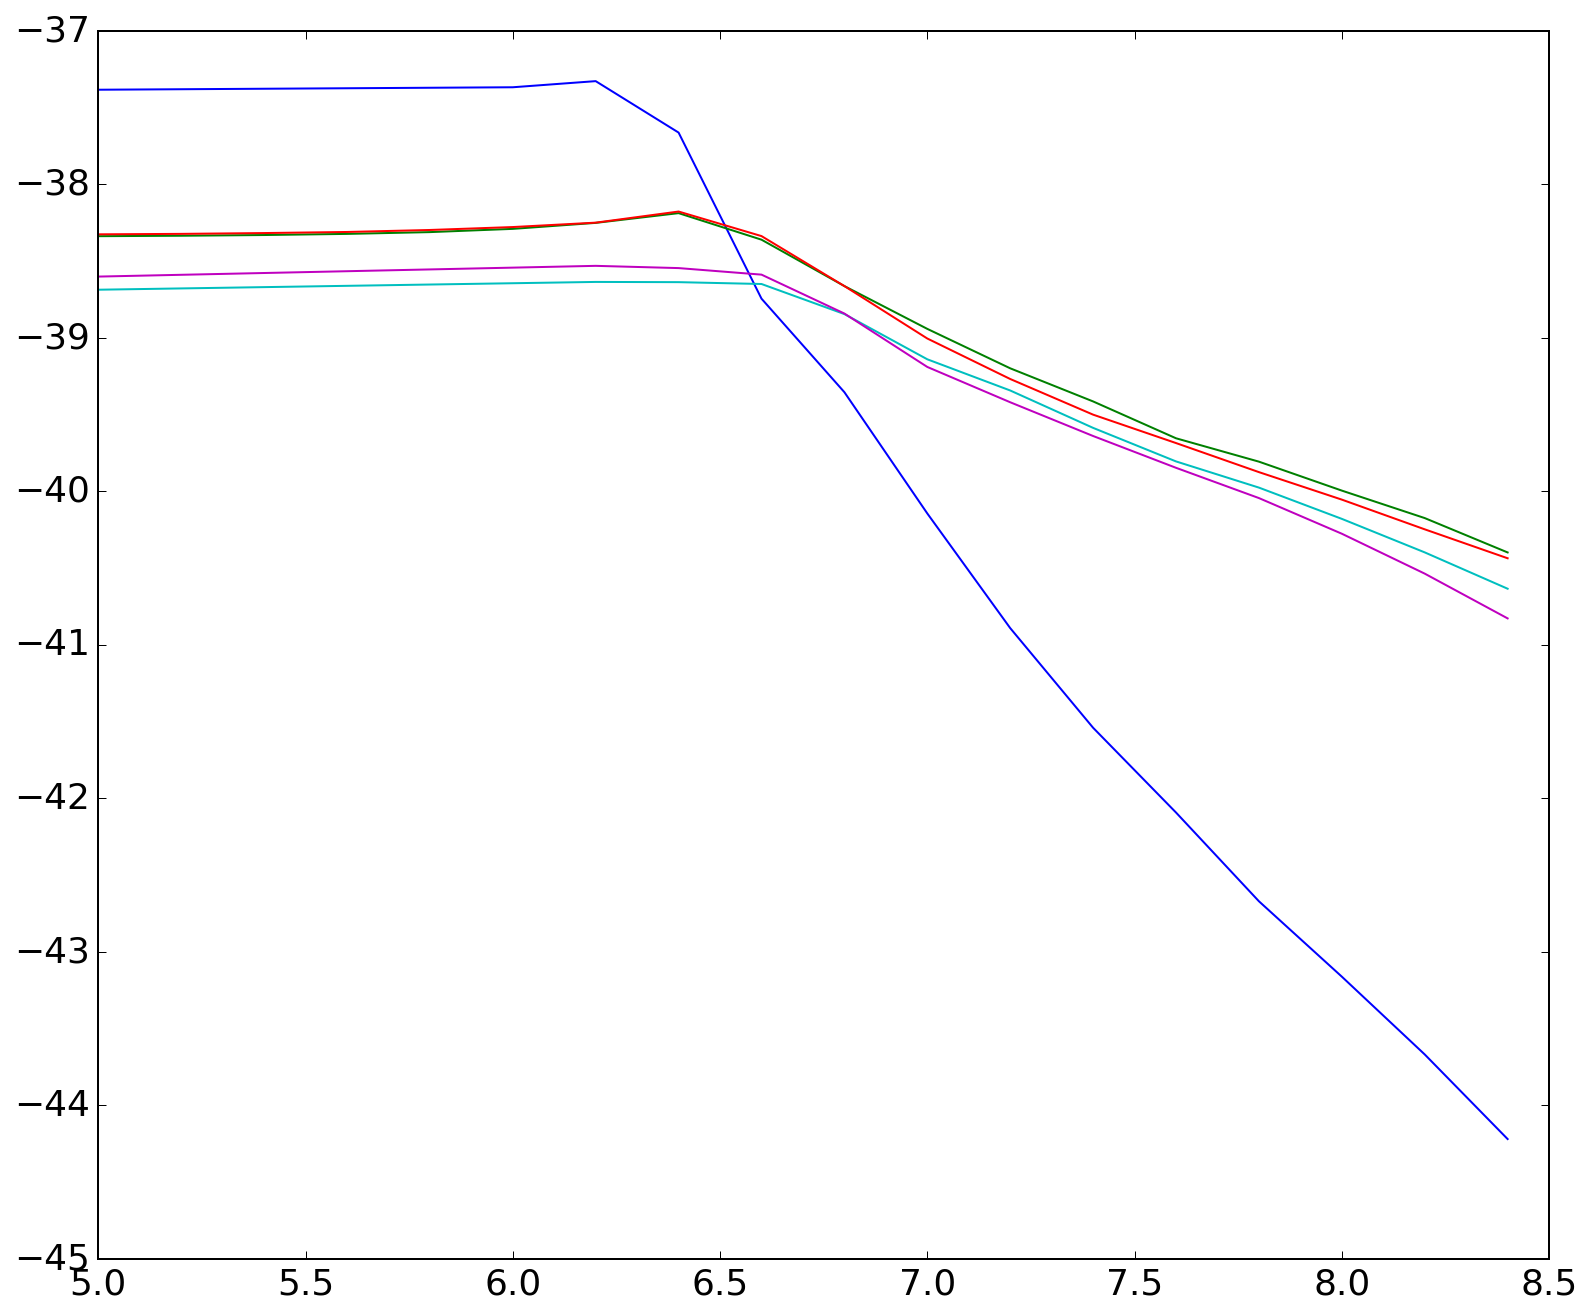

In [183]:
plt.plot(np.arange(5,8.6,0.2),flux[0]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[1e-7]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[1e-5]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[4e-3]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[0.02]['f430m'](np.arange(5,8.6,0.2)))

In [142]:
spAge = 1e6
np.log10([spAge for i in Zs])

array([ 6.,  6.,  6.,  6.,  6.,  6.,  6.])

In [141]:
np.log10(halospages*1e6)

array([ 7.25826658,  7.31545708,  7.40218995, ...,  7.55637994,
        7.78737811,  7.69748605])

In [111]:
haloFiltTots['f115w'] += 1.0

In [125]:
flux[0]['f115w']

In [135]:
Zs = sorted(flux.keys())
for a in Zs:
    print("{:.1e}".format(a))

0.0e+00
1.0e-07
1.0e-05
4.0e-04
4.0e-03
8.0e-03
2.0e-02


In [129]:
sorted(flux.keys())

[0, 1e-07, 1e-05, 0.0004, 0.004, 0.008, 0.02]